# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
Целевой признак
- Price — цена (евро)

## Подготовка данных

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [20]:
df = pd.read_csv('/datasets/autos.csv')
df.info()
display(df.head())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Наблюдаем в данных много пропусков, ненужных столбцов, начнем обрабатывать

In [21]:
df['DateCrawled'].str[:4].describe()

count     354369
unique         1
top         2016
freq      354369
Name: DateCrawled, dtype: object

In [22]:
df['DateCreated'].str[:4].unique()

array(['2016', '2015', '2014'], dtype=object)

Обратим внимание, что все анкеты были скачаны в 2016 году.

In [23]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen','RegistrationMonth'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Можем удалить эти столбцы т.к. дата скачивания анкеты и дата создания анкеты не нужны нам. Кол-во картинок, почтовый индекс владельца и дата последней активности, так же не принесут никакой пользы

In [24]:
df['Repaired'] = df['Repaired'].fillna(0)
df.loc[df['Repaired']=='no', 'Repaired'] = 0
df.loc[df['Repaired']=='yes', 'Repaired'] = 1
df['Repaired'].unique()

array([0, 1], dtype=object)

Приведем этот столбец к числовому формату

In [25]:
display(df['RegistrationYear'].unique())
df = df[df['RegistrationYear'] < 2017]
df = df[df['RegistrationYear'] >= 1990]

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

Избавимся от выбросов в столбце с годом регистрации

In [26]:
df = df[df['Price'] > 499]
df['Price'].describe()

count    297008.000000
mean       4937.937648
std        4540.092951
min         500.000000
25%        1499.000000
50%        3250.000000
75%        6999.000000
max       20000.000000
Name: Price, dtype: float64

Установим разумную минимальну. цену, согласно данным из интернета

In [27]:
df = df[df['Power'] < 2000]
df = df[df['Power'] > 9]
df['Power'].describe()

count    272855.000000
mean        124.235807
std          62.082130
min          10.000000
25%          82.000000
50%         116.000000
75%         150.000000
max        1998.000000
Name: Power, dtype: float64

Так же, проведя небольшое исследование, 2000 л.с. примерно максимальное значение, которыми обладают суперкары, так что избавимся от всех значений выше. Так же минимально низкие значения, которые мне удалось обнаружить находятся около 10. Построим матрицу корреляции

<AxesSubplot:>

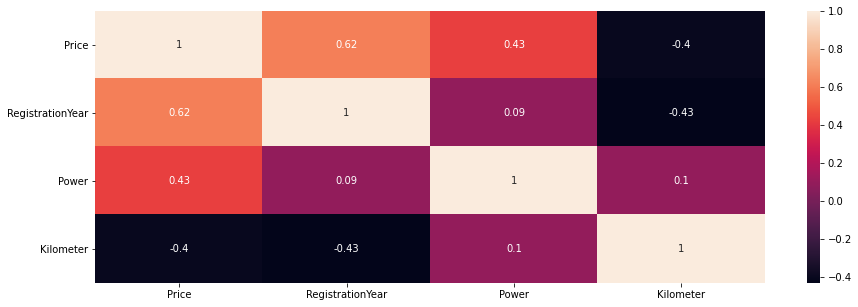

In [28]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr().round(2),annot=True)

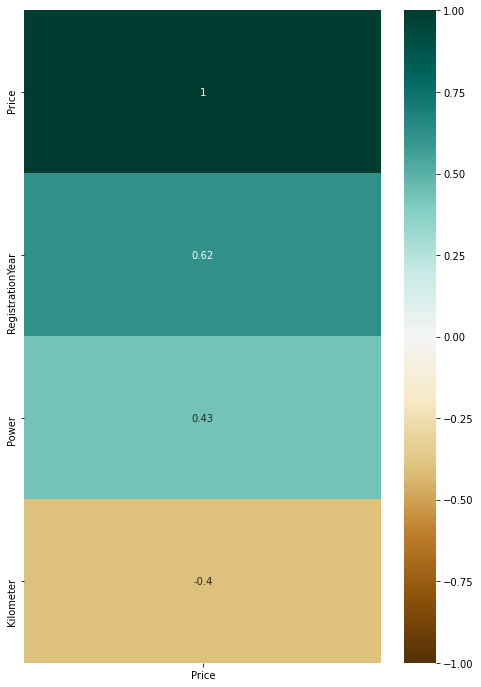

In [29]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr().round(2)[['Price']].sort_values(by='Price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

Видим сильную зависимость целевого признака от мощности, поэтому обратим на него особое внимание

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Power'>

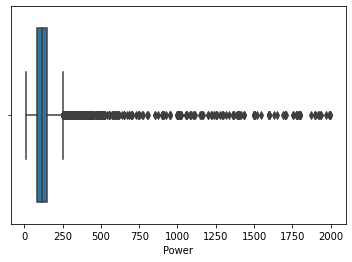

In [30]:
sns.boxplot(df['Power'])

In [31]:
i = 0
while True:
    i += 10    
    if len(df[df['Power'] >= i])/len(df) < 0.01:
        print(i)
        break

310


Видим, что с мощностью больше, чем 300, хранится меньше одного процента данных, так что избавимся от них


In [32]:
df = df[df['Power'] < 310]

In [33]:
df = df.fillna('unknown')

In [34]:
df[df['Power'] > 142].corr()

,Price,RegistrationYear,Power,Kilometer,Repaired
Price,1.000000,0.682474,0.288574,-0.442091,-0.216374
RegistrationYear,0.682474,1.000000,0.016521,-0.359659,-0.104544
Power,0.288574,0.016521,1.000000,0.024869,-0.027345
Kilometer,-0.442091,-0.359659,0.024869,1.000000,0.067444
Repaired,-0.216374,-0.104544,-0.027345,0.067444,1.000000


In [35]:
len(df.query('Power > 200')) / len(df) 

0.06980981454515889

In [36]:
display(df.isna().sum())
df.describe()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

,Price,RegistrationYear,Power,Kilometer,Repaired
count,270578.000000,270578.000000,270578.000000,270578.000000,270578.000000
mean,5066.925445,2003.612781,121.639317,128031.528801,0.082442
std,4557.626661,5.384172,49.342803,36597.273076,0.275037
min,500.000000,1990.000000,10.000000,5000.000000,0.000000
25%,1500.000000,2000.000000,82.000000,125000.000000,0.000000
50%,3499.000000,2004.000000,116.000000,150000.000000,0.000000
75%,7200.000000,2007.000000,150.000000,150000.000000,0.000000
max,20000.000000,2016.000000,309.000000,150000.000000,1.000000


## Обучение моделей

In [37]:
features = df.drop('Price', axis = 1)
target = df['Price']

In [38]:
features_train, features_test, target_train, target_test = train_test_split( 
        features, target, test_size=0.4, random_state=12345
)

In [39]:
display(features_train.shape, target_train.shape, features_test.shape, target_test.shape)

(162346, 9)

(162346,)

(108232, 9)

(108232,)

In [40]:
def type_switcher(df, columns):
    for column in columns:
        df[column] = df[column].astype('category')
        df[column] = df[column].cat.codes

Приведем категоральные столбцы к числовому формату

In [41]:
category =['VehicleType','Gearbox', 'Model','FuelType','Brand']
type_switcher(features_train, category)
type_switcher(features_test, category)

/tmp/ipykernel_31/114341857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')
/tmp/ipykernel_31/114341857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].cat.codes


In [42]:
display(features_train.head())
features_train.describe()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
287022,8,2006,0,140,219,150000,2,38,0
240369,5,2001,1,75,75,150000,6,27,0
320845,0,2004,1,90,166,150000,2,5,0
322774,5,2007,0,84,106,60000,6,32,0
135392,7,2005,0,170,11,150000,7,2,0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
count,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000
mean,4.559650,2003.611373,0.813768,121.708980,110.264910,128087.726214,4.728974,20.579602,0.081868
std,2.437479,5.380202,0.428032,49.379211,72.647231,36536.809685,1.910535,13.443719,0.274165
min,0.000000,1990.000000,0.000000,10.000000,0.000000,5000.000000,0.000000,0.000000,0.000000
25%,4.000000,2000.000000,1.000000,82.000000,42.000000,125000.000000,2.000000,9.000000,0.000000
50%,5.000000,2004.000000,1.000000,116.000000,112.000000,150000.000000,6.000000,23.000000,0.000000
75%,6.000000,2007.000000,1.000000,150.000000,169.000000,150000.000000,6.000000,33.000000,0.000000
max,8.000000,2016.000000,2.000000,309.000000,247.000000,150000.000000,7.000000,39.000000,1.000000


Начснем обучать модели.

### RandomForrestRegressor

In [43]:
%%time
rfr = RandomForestRegressor(random_state=12345)#Исследуем модель дерева решений
param_grid_rfr = { # словарь параметров
    'max_depth':[5,7,9,11,13],
    'min_samples_leaf':[2,4],    
    'n_estimators': [10, 20, 30]    
}

#воспользуемся методом GridSearchCV для подбора параметров
grid_CV_rfr = GridSearchCV(estimator=rfr,
                       param_grid=param_grid_rfr,
                       cv=5,
                       scoring='neg_root_mean_squared_error'
)
grid_CV_rfr.fit(features_train, target_train)


print(grid_CV_rfr.best_score_)

-1598.647191827782
CPU times: user 6min 19s, sys: 1.41 s, total: 6min 21s
Wall time: 6min 21s


В кроссвалидации добились нужного значения метрики.

### LightGBM

In [44]:
%%time
lgbmr = LGBMRegressor(random_state=12345)
param_grid_lgbmr = { # словарь параметров
    'max_depth':[5,7,9,11],
    'num_leaves':[20,40],    
        
}

#воспользуемся методом GridSearchCV для подбора параметров
grid_CV_lgbmr = GridSearchCV(estimator=lgbmr,
                       param_grid=param_grid_lgbmr,
                       cv=5,
                       scoring='neg_root_mean_squared_error'
)
grid_CV_lgbmr.fit(features_train, target_train)

print(abs(grid_CV_lgbmr.best_score_))

1561.9382037381044
CPU times: user 2min 2s, sys: 537 ms, total: 2min 2s
Wall time: 2min 3s


Так же в кроссвалидации добились нужного значения метрики. Однако оно получилось лучше, чем у другой модели

## Анализ моделей

Посмотрим скорость предсказания на тестовых данных.

In [45]:
features_test.shape

(108232, 9)

In [46]:
results = pd.DataFrame(grid_CV_rfr.cv_results_)
display(results)
display(results[results['rank_test_score']==1])
fit_time = results[results['rank_test_score']==1]['mean_fit_time'].values[0]
predict_time = results[results['rank_test_score']==1]['mean_score_time'].values[0]
print(f'Fit time: {fit_time}, predict time: {predict_time}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.871379,0.031389,0.016513,0.000454,5,2,10,"{'max_depth': 5, 'min_samples_leaf': 2, 'n_est...",-2259.228994,-2266.265777,-2271.457035,-2287.958853,-2297.543425,-2276.490817,14.160432,27
1,1.601753,0.011886,0.028958,0.001721,5,2,20,"{'max_depth': 5, 'min_samples_leaf': 2, 'n_est...",-2256.449343,-2269.374199,-2273.828553,-2288.415116,-2294.515402,-2276.516522,13.612243,29
2,2.437170,0.041990,0.041334,0.000788,5,2,30,"{'max_depth': 5, 'min_samples_leaf': 2, 'n_est...",-2254.464253,-2265.786975,-2277.147326,-2291.181014,-2292.431963,-2276.202306,14.626542,25
3,0.822474,0.016453,0.016476,0.000965,5,4,10,"{'max_depth': 5, 'min_samples_leaf': 4, 'n_est...",-2259.228994,-2266.265777,-2271.457035,-2287.958853,-2297.543425,-2276.490817,14.160432,27
4,1.635424,0.020823,0.028413,0.000548,5,4,20,"{'max_depth': 5, 'min_samples_leaf': 4, 'n_est...",-2256.449343,-2269.374199,-2273.828553,-2288.415116,-2294.515402,-2276.516522,13.612243,29
5,2.308273,0.044184,0.040603,0.000905,5,4,30,"{'max_depth': 5, 'min_samples_leaf': 4, 'n_est...",-2254.464253,-2265.786975,-2277.147326,-2291.181014,-2292.431963,-2276.202306,14.626542,25
6,1.018334,0.040810,0.020682,0.000499,7,2,10,"{'max_depth': 7, 'min_samples_leaf': 2, 'n_est...",-1997.933498,-2000.696936,-2016.917086,-2012.402034,-2014.848255,-2008.559562,7.731683,24
7,2.019251,0.024895,0.037421,0.000678,7,2,20,"{'max_depth': 7, 'min_samples_leaf': 2, 'n_est...",-1996.631476,-2001.601922,-2013.499928,-2009.692377,-2011.353088,-2006.555758,6.389149,22
8,3.049169,0.040803,0.054680,0.000242,7,2,30,"{'max_depth': 7, 'min_samples_leaf': 2, 'n_est...",-1994.896653,-2000.844278,-2014.490262,-2010.906876,-2009.149663,-2006.057546,7.154461,19
9,1.026572,0.028223,0.020879,0.000753,7,4,10,"{'max_depth': 7, 'min_samples_leaf': 4, 'n_est...",-1997.673070,-2000.340241,-2016.868160,-2012.723595,-2014.767984,-2008.474610,7.886106,23


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,4.925501,0.085643,0.125719,0.001402,13,2,30,"{'max_depth': 13, 'min_samples_leaf': 2, 'n_es...",-1584.665057,-1599.385553,-1618.117176,-1588.540185,-1602.527988,-1598.647192,11.767223,1


Fit time: 4.925500535964966, predict time: 0.12571916580200196


In [47]:
results = pd.DataFrame(grid_CV_lgbmr.cv_results_)
display(results)
display(results[results['rank_test_score']==1])
fit_time = results[results['rank_test_score']==1]['mean_fit_time'].values[0]
predict_time = results[results['rank_test_score']==1]['mean_score_time'].values[0]
print(f'Fit time: {fit_time}, predict time: {predict_time}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.266781,0.061574,0.203829,0.001762,5,20,"{'max_depth': 5, 'num_leaves': 20}",-1628.084430,-1650.549454,-1662.936028,-1653.769642,-1640.926878,-1647.253287,11.889024,8
1,2.654281,0.271871,0.203652,0.001141,5,40,"{'max_depth': 5, 'num_leaves': 40}",-1615.431515,-1632.337977,-1642.126224,-1638.372346,-1624.147528,-1630.483118,9.674015,7
2,2.500676,0.270579,0.236487,0.040552,7,20,"{'max_depth': 7, 'num_leaves': 20}",-1613.152612,-1631.881457,-1647.317871,-1634.230413,-1622.287279,-1629.773926,11.527445,6
3,3.019699,0.113736,0.280114,0.036684,7,40,"{'max_depth': 7, 'num_leaves': 40}",-1562.440079,-1576.050374,-1592.162892,-1578.462509,-1570.346686,-1575.892508,9.829336,3
4,2.339557,0.097258,0.240511,0.041518,9,20,"{'max_depth': 9, 'num_leaves': 20}",-1606.870753,-1627.158995,-1638.774807,-1631.728554,-1618.786043,-1624.663830,11.012700,5
5,3.300496,0.225369,0.296826,0.003103,9,40,"{'max_depth': 9, 'num_leaves': 40}",-1551.868251,-1567.373483,-1586.915591,-1565.417828,-1560.445246,-1566.404079,11.570934,2
6,2.678456,0.311858,0.258918,0.043432,11,20,"{'max_depth': 11, 'num_leaves': 20}",-1608.684145,-1623.422346,-1637.669352,-1631.009745,-1617.240396,-1623.605197,10.156867,4
7,3.141413,0.083298,0.298778,0.002285,11,40,"{'max_depth': 11, 'num_leaves': 40}",-1546.419249,-1565.798140,-1579.911819,-1560.952584,-1556.609227,-1561.938204,11.028666,1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,3.141413,0.083298,0.298778,0.002285,11,40,"{'max_depth': 11, 'num_leaves': 40}",-1546.419249,-1565.79814,-1579.911819,-1560.952584,-1556.609227,-1561.938204,11.028666,1


Fit time: 3.1414134979248045, predict time: 0.2987782955169678


Видим, что хоть значение метрики у бустинга и лучше, по всем остальным параметрам он сильно проигрывает

## Вывод

Проверим значение метрики на тестовых данных

In [48]:
print('RMSE = ', mean_squared_error(target_test, grid_CV_rfr.predict(features_test))**0.5)

RMSE =  1621.8637412890153


В данном проекте мы выполнили следующее:
- Провели предобработку данных.
- Обучили разные модели. Для каждой модели попробовали разные гиперпараметры
- Проанализировали обе модели согласно критериям заказчика и пришли к следующему выводу: RandomForrestRegressor использовать выгоднее, т.к. он проиграл другой модели только в значении исследуемой метрики, хотя и прошел пороговое значение на неё, но по всем другим параметрам уверенно лидирует
- Согласно нашему выбору проверили модель на тестовых данных, убедились, что значение метрики ниже порогового